## Loading 3D pose output files
This short script demonstrates how to load and visualise the generated datasets.

Each dataset consists of 3 file types:
* **n** images
* **1** 3D pose dataframe
* **1** label lookup table, containing keypoint names

The **.hdf5** formatted file dataframe contains the following entries for each generated image:

*	  file_name &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1 string (relative)
*	  rot_mat	&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3 x 3 float
*	  trans_mat	&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3 x 1 float
*	  intrinsics_mat &nbsp;&nbsp;&nbsp; 3 x 3 float
*     bounding_box &nbsp;&nbsp;&nbsp; 4 x 1 float
*	  key_points_3D &nbsp;&nbsp;&nbsp;3 x k float (provide name sheet)
*	  key_points_2D &nbsp;&nbsp;&nbsp;2 x k float
*	  visibility &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1 x k int (0 occluded or 1 visible)

In [1]:
import os
import cv2

import numpy as np
import pandas as pd

target_dir = "../data/single_sungaya/"

out_df = pd.read_hdf("../data/single_sungaya/Data_3D_Pose.hdf5")
out_df

,file_name,cam_rot,cam_trans,cam_intrinsics,bounding_box,key_points_3D,key_points_2D,visibility
0,1002_Img_synth.png,"[[0.299712, -0.685369, -0.663658], [-0.95103, ...","[-206.887, -85.8906, 871.54]","[[1600.000244, 0.0, 320.0], [0.0, 1600.000244,...","[0, 84, 414, 595]","[[-3.047812, -269.825287, 96.387993], [-10.202...","[[95.407867, 384.01593], [129.091675, 351.2847...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1005_Img_synth.png,"[[0.432294, 0.464133, 0.773112], [0.707314, -0...","[50.4178, -487.672, 600.386]","[[1600.000244, 0.0, 320.0], [0.0, 1600.000244,...","[223, 156, 640, 640]","[[231.146606, -368.931488, 96.387993], [246.39...","[[502.015533, 526.509338], [489.601746, 452.79...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,1006_Img_synth.png,"[[-0.0613171, 0.973666, 0.21958], [0.817173, 0...","[-366.074, -101.078, 698.515]","[[1600.000244, 0.0, 320.0], [0.0, 1600.000244,...","[185, 231, 640, 589]","[[49.874466, 377.015411, 96.387993], [41.18921...","[[367.270233, 436.59491], [412.659454, 438.565...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1011_Img_synth.png,"[[0.980659, 0.137138, -0.13965], [0.145579, -0...","[208.431, -47.2549, 640.152]","[[1600.000244, 0.0, 320.0], [0.0, 1600.000244,...","[0, 96, 384, 615]","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0], [0, 0], [0, 0], [0, 0], [204.477234, ...","[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1015_Img_synth.png,"[[-0.968932, -0.23072, -0.0891025], [-0.238785...","[-101.129, -125.773, 646.068]","[[1600.000244, 0.0, 320.0], [0.0, 1600.000244,...","[145, 0, 607, 401]","[[-184.588226, 150.16156, 96.387993], [-167.59...","[[402.672729, 101.495071], [371.821045, 139.67...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...
3773,9981_Img_synth.png,"[[0.703921, -0.425377, 0.568814], [-0.710277, ...","[43.5846, 91.6788, 864.243]","[[1600.000244, 0.0, 320.0], [0.0, 1600.000244,...","[206, 92, 640, 429]","[[37.699928, 197.113602, 96.387993], [47.36378...","[[421.396729, 229.956238], [449.737854, 234.33...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3774,9994_Img_synth.png,"[[-0.775938, 0.485034, -0.403313], [0.428827, ...","[-39.4346, 121.901, 591.735]","[[1600.000244, 0.0, 320.0], [0.0, 1600.000244,...","[0, 0, 480, 554]","[[-116.847282, -72.601166, 96.387993], [-95.30...","[[239.093399, 213.272491], [186.209488, 192.51...","[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3775,9995_Img_synth.png,"[[-0.777703, -0.54052, 0.320961], [-0.58631, 0...","[-136.092, -193.223, 454.104]","[[1600.000244, 0.0, 320.0], [0.0, 1600.000244,...","[138, 116, 640, 640]","[[0, 0, 0], [0, 0, 0], [-275.554962, 109.75146...","[[0, 0], [0, 0], [631.721497, 620.308716], [0,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3776,9999_Img_synth.png,"[[0.984181, -0.131343, -0.118895], [-0.0615904...","[-257.347, -729.683, 270.749]","[[1600.000244, 0.0, 320.0], [0.0, 1600.000244,...","[0, 0, 498, 479]","[[105.463318, -854.950378, 96.387993], [125.97...","[[167.771988, 136.572433], [224.189758, 161.59...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def set_axes_equal(ax):
    # workaround, as matplotlib's 3D plot has no option for equisised axes (10/2021)
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

### Load and display 3D coordinates
Change **show_entry** to the id of the sample, you want to examine

Check the dataframe above to see which id corresponds to which image.

In [3]:
def plot_stick_bug(ax, points, simple=False):
    limb_ranges=[[0,7],[8,14],[15,21],[22,28],[29,35],[36,42],[43,49],[53,56],[59,62]]
    if len(points) < 62:
        return
    elif len(points) == 62:
        points = np.array(points).T
        if not simple:
            for (fr,end) in limb_ranges:
                ax.plot(points[0][fr:end], points[1][fr:end], points[2][fr:end])
                ax.scatter(points[0][fr:end], points[1][fr:end], points[2][fr:end], marker='o',s=10)
            return ax


In [4]:
z= np.zeros((62))
for col, x in out_df.iterrows():
    z += np.array(x['visibility'])
print(np.argmax(z))
z

42


array([3031., 3192., 3266., 3147., 3029., 2813., 2593., 3111., 3112.,
       3100., 2891., 2880., 2881., 2845., 3275., 3287., 3300., 3186.,
       3252., 3189., 3159., 3294., 3293., 3294., 3099., 3188., 3068.,
       3027., 3235., 3084., 3078., 2972., 3090., 3050., 2969., 3275.,
       3281., 3265., 3140., 3248., 3242., 3213., 3301., 3294., 3294.,
       3100., 3271., 3213., 3170., 3221., 3012., 2988., 2922., 2689.,
       2279., 2167., 3012., 2991., 2899., 2661., 2358., 2321.])

In [5]:
filefind = "7744_Img_synth.png"
out_df.loc[out_df['file_name'] == filefind]


,file_name,cam_rot,cam_trans,cam_intrinsics,bounding_box,key_points_3D,key_points_2D,visibility
2863,7744_Img_synth.png,"[[0.926263, -0.150444, 0.345548], [-0.145596, ...","[-22.7657, 31.9103, 604.705]","[[1600.000244, 0.0, 320.0], [0.0, 1600.000244,...","[291, 108, 640, 640]","[[0, 0, 0], [93.33226, 36.472122, 92.693718], ...","[[0, 0], [582.593079, 382.426331], [542.301575...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, ..."


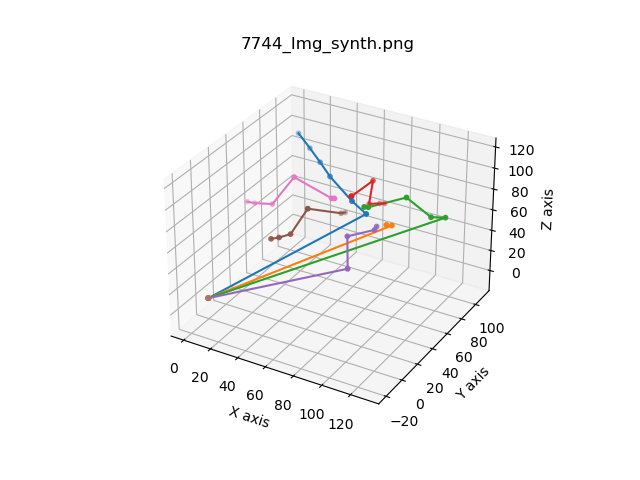

In [8]:
show_entry = 2863
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

display_points_3D = out_df.loc[show_entry]["key_points_3D"]
display_img = cv2.imread(os.path.join(target_dir, out_df.loc[show_entry]["file_name"]))

plot_stick_bug(ax, display_points_3D)
# for i,xyz in enumerate(display_points_3D):
#     if out_df.loc[show_entry]["visibility"][i] == 1:
#         if i== 6:
#             ax.scatter(xyz[0], xyz[1], xyz[2]-2.5, marker='o',s=10)

# """
# # additionally, plot the camera location
# ax.scatter(out_df.loc[show_entry]["cam_trans"][0], 
#            out_df.loc[show_entry]["cam_trans"][1], 
#            out_df.loc[show_entry]["cam_trans"][2], marker='x')
# """

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# use custom function to ensure equal axis proportions
set_axes_equal(ax)

# # opens external plot
plt.title(out_df.loc[show_entry]["file_name"])
plt.show()

### Load and display 2D coordinates 
as well as **3D coordinates** projected onto the **camera view**.

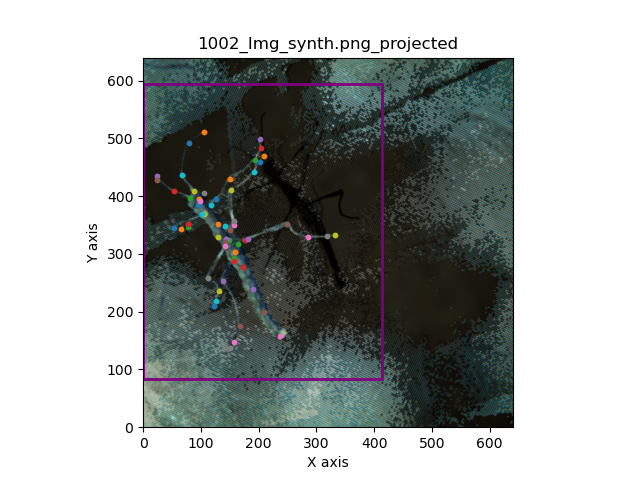

In [7]:
# file_name	cam_rot	cam_trans	cam_intrinsics	bounding_box	key_points_3D	key_points_2D	visibility
R = np.array(out_df.loc[show_entry]["cam_rot"])
T = np.reshape(np.array(out_df.loc[show_entry]["cam_trans"]),(3,1))
C = np.array(out_df.loc[show_entry]["cam_intrinsics"])
bbox = np.array(out_df.loc[show_entry]["bounding_box"])

fig = plt.figure()
ax = fig.add_subplot()

# display the generated image
ax.imshow(display_img)
rect=plt.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1], 
                        fill = False,
                        color = "purple",
                        linewidth = 2)
    
for i, x in enumerate(display_points_3D):
    X = np.reshape(np.array(out_df.loc[show_entry]["key_points_3D"][i]),(3,-1))

#     # given the above data, it should be possible to project the 3D points into the corresponding image,
#     # so they land in the correct position on the image 
    P = C @ np.hstack([R, T])  # projection matrix
    X_hom = np.vstack([X, np.ones(X.shape[1])])  # 3D points in homogenous coordinates

    X_hom = P @ X_hom  # project the 3D points
    
    X_2d = X_hom[:2, :] / X_hom[2, :]  # convert them back to 2D pixel space
    
    gt_x_2d = out_df.loc[show_entry]["key_points_2D"][i][0]
    gt_y_2d = out_df.loc[show_entry]["key_points_2D"][i][1]
    
    ax.scatter(gt_x_2d, gt_y_2d, marker='o', s=10)
    # ax.scatter(X_2d[0], display_img.shape[1]-X_2d[1], marker='^', s=2) #3d projected points

# Displays specific joints
# i, o = 3, 3
# for i in range(i-1,o):
#     gt_x_2d = out_df.loc[show_entry]["key_points_2D"][i][0]
#     gt_y_2d = out_df.loc[show_entry]["key_points_2D"][i][1]
#     ax.scatter(gt_x_2d, gt_y_2d, marker='o', s=10)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

ax.set_xlim([0,display_img.shape[0]])
ax.set_ylim([0,display_img.shape[1]])
ax.set_aspect('equal')

plt.gca().add_patch(rect)

plt.title(out_df.loc[show_entry]["file_name"] + "_projected")
plt.show()